In [1]:
import os

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter
from epiweeks import Week
from datetime import datetime, timedelta
from matplotlib.patches import Circle
import matplotlib.ticker
from matplotlib.lines import Line2D
import numpy as np
from utils import timeseries_formatting, basic_formatting, dec_to_date, hpd, _toYearFraction, get_okabe_ito_palette
from dendropy import TreeList, Tree
import time
import seaborn as sns
import matplotlib.patheffects as PathEffects
import geopandas as gpd
from matplotlib.colors import Normalize
import matplotlib.cm as mcm
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import haversine_distances

prop = mpl.font_manager.FontProperties('Roboto')
mpl.rcParams['font.sans-serif'] = prop.get_name()
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.size']=16

COLOR = '#343434'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

# Figure 1: San Diego's genomic similarity to other locations in North America
We use the PhyloSor metric to measure the genomic similarity between San Diego and a number of other locations in North America, and determine that the county is regionally connected.

Load in the results from the phylosor analysis. These are the output of the `monterey` pipeline.

In [2]:
def load_results( loc, source, min_sequences = 0 ):
    """ Loads PhyloSor results from file.
    Parameters
    ----------
    loc : str
        Path to concatenated results files
    source : str
        Location to filter results to. Must be found in "siteA" column
    min_sequences : int
        Minimum number of genomes that both siteA and siteB must have for measurement to be included

    Returns
    -------
    pandas.DataFrame
        PhyloSor results
    """
    df = pd.read_csv( loc, parse_dates=["date"] )
    df = df.loc[df["siteA"]==source]
    df = df.loc[(df["countA"]>=min_sequences)&(df["countB"]>=min_sequences)]
    df["kind"] = df["kind"].fillna( "null" )
    df["kind"] = df["kind"] + df["num"].astype( str )
    df = df.drop( columns=["num"] )
    return df

def correct_names( entry ):
    return_value = entry.replace( "_", ", " )
    if return_value in ["British Columbia", "Ontario", "Alberta", "Québec", "Saskatchewan", "Manitoba", "Nova Scotia"]:
        return_value += ", CAN"
    elif return_value in ["Baja California", "Yucatán"]:
        return_value += ", MEX"
    return return_value

res = load_results( "../data/phylosor_newnull_results.csv", source="San Diego_CA", min_sequences=30 )
res["siteB"] = res["siteB"].apply( correct_names )
res.head()

,blA,blB,blBoth,date,siteA,countA,siteB,countB,value,value_turn,kind
0,0.003612,0.005819,0.001271,2020-03-01,San Diego_CA,32,"Texas, USA",59,0.269504,0.351852,null1
1,0.006555,0.017456,0.002174,2020-04-01,San Diego_CA,46,"Texas, USA",146,0.181059,0.331633,null1
2,0.014480,0.030465,0.003913,2020-05-01,San Diego_CA,103,"Texas, USA",235,0.174107,0.270208,null1
3,0.019730,0.108283,0.009163,2020-06-01,San Diego_CA,90,"Texas, USA",724,0.143156,0.464407,null1
4,0.037287,0.554025,0.019764,2020-07-01,San Diego_CA,122,"Texas, USA",3778,0.066848,0.530045,null1


Phylosor similarity is calculated on a monthly basis. To calculate a summary across time, we min-max normalize the values for each month and plot the distribution of similarity for each location.

TODO: color by wave

In [3]:
def calculate_order( results, normalize=True ):
    return_df = results.loc[results["kind"]=="actual1"]
    return_df = return_df.pivot( index="siteB", columns="date", values="value" )
    if normalize:
        return_df = (return_df-return_df.min())/(return_df.max()-return_df.min())
    return return_df

norm_values = calculate_order( res )
orders = norm_values.median( axis=1 ).sort_values( ascending=False ).index
norm_values = norm_values.reindex( index=orders )

#plot_df = orders.iloc[:20]
#plot_mean = plot_df.median( axis=1 ).reset_index().reset_index()
#plot_df = plot_df.melt( var_name="date", value_name="value", ignore_index=False ).reset_index()
#
#plot_df2 = orders.iloc[20:]
#plot_mean2 = plot_df2.median( axis=1 ).reset_index().reset_index()
#plot_df2 = plot_df2.melt( var_name="date", value_name="value", ignore_index=False ).reset_index()
#
#fig, ax = plt.subplots( dpi=200, figsize=(8,8), nrows=2, sharey=True )
##hue_order = ["<10", "10-99", "100-999", ">1000"]
##paletee = ["#E69F00", "#56B4E9", "#009E73", "#F0E442"]
#sns.swarmplot( x="siteB", y="value", data=plot_df, size=2.9, ax=ax[0], color="#56B4E9" )
#sns.swarmplot( x="siteB", y="value", data=plot_df2, size=2.9, ax=ax[1], color="#56B4E9" )
#ln = ax[0].hlines( plot_mean[0], xmin=plot_mean["index"]-0.25, xmax=plot_mean["index"]+0.25, color="black", linewidth=1, zorder=100 )
#ln.set_capstyle( "round" )
#ln = ax[1].hlines( plot_mean2[0], xmin=plot_mean2["index"]-0.25, xmax=plot_mean2["index"]+0.25, color="black", linewidth=1, zorder=100 )
#ln.set_capstyle( "round" )
#
#basic_formatting( ax[0], ylabel="Normalized PhyloSor similarity", xlabel="", ysize=10, xsize=8 )
#basic_formatting( ax[1], ylabel="Normalized PhyloSor similarity", xlabel="", xlims=ax[0].get_xlim(), ysize=10, xsize=10 )
#
#plt.tight_layout()
#plt.savefig( f"../analyses/plots/figure1_phylosor-norm-summary.pdf" )
#plt.show()

In [4]:
states = gpd.read_file( "/Users/natem/Data/raw_data/shapefiles/NA_states/bound_p.shx" )
states = states.loc[states["COUNTRY"].isin(["USA", "MEX", "CAN"])]
states = states.drop( columns=["OBJECTID", "BOUND_P_", "UIDENT", "STATEABB", "Shape_Area", "Shape_Leng"])
states = states.dissolve( "NAME" ).reset_index()
states["NAME"] = states["NAME"].replace( {"British Columbia / Colombie-Britannique": "British Columbia", "Quebec / Québec" : "Québec", "Nova Scotia / Nouvelle-Écosse" : "Nova Scotia"} )
states["NAME"] = states["NAME"] + ", " + states["COUNTRY"]
states = states.loc[~states["NAME"].isin( ["California, USA","water/agua/d'eau, CAN"] )]

ca = gpd.read_file( "/Users/natem/Data/raw_data/shapefiles/USA_county/gadm36_USA_2.shx" )
ca = ca.loc[ca["NAME_1"]=="California",["NAME_2", "geometry"]]
ca["COUNTRY"] = "USA"
ca.columns = ["NAME", "geometry", "COUNTRY"]
ca = ca.dissolve( "NAME").reset_index()
ca["NAME"] = ca["NAME"] + ", CA"

states = pd.concat( [states,ca], ignore_index=True )

# Haversine great circle distance
#states["longitude"] = states.centroid.x * (np.pi / 180)
#states["latitude"] = states.centroid.y * (np.pi / 180)
#states["distance"] = haversine_distances( states[["latitude","longitude"]] )[states.loc[states["NAME"]=="San Diego, CA"].index].T
states = states.to_crs( "EPSG:2163" )
states["geometry"] = states.simplify(1000)
states["distance"] = states.distance( states.loc[states["NAME"]=="San Diego, CA","geometry"].centroid.values[0] ) / 1000 # KM
states["distance"] = np.log10( states["distance"] )

states

/usr/local/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,NAME,geometry,COUNTRY,distance
0,"Aguascalientes, MEX","POLYGON ((-198707.008 -2544337.499, -200108.56...",MEX,3.266495
1,"Alabama, USA","MULTIPOLYGON (((1198230.009 -1542943.613, 1197...",USA,3.420814
2,"Alaska, USA","MULTIPOLYGON (((-4329592.097 3293651.237, -433...",USA,3.426423
3,"Alberta, CAN","POLYGON ((-558692.930 1700003.618, -644121.433...",CAN,3.253048
4,"Arizona, USA","POLYGON ((-803220.067 -845640.068, -863633.459...",USA,2.273259
...,...,...,...,...
152,"Tulare, CA","POLYGON ((-1614470.731 -849845.881, -1748643.8...",USA,2.518503
153,"Tuolumne, CA","POLYGON ((-1681571.031 -606535.609, -1686263.2...",USA,2.760637
154,"Ventura, CA","MULTIPOLYGON (((-1804993.313 -1092190.779, -17...",USA,2.345810
155,"Yolo, CA","POLYGON ((-1912797.619 -421462.105, -1913904.6...",USA,2.869755


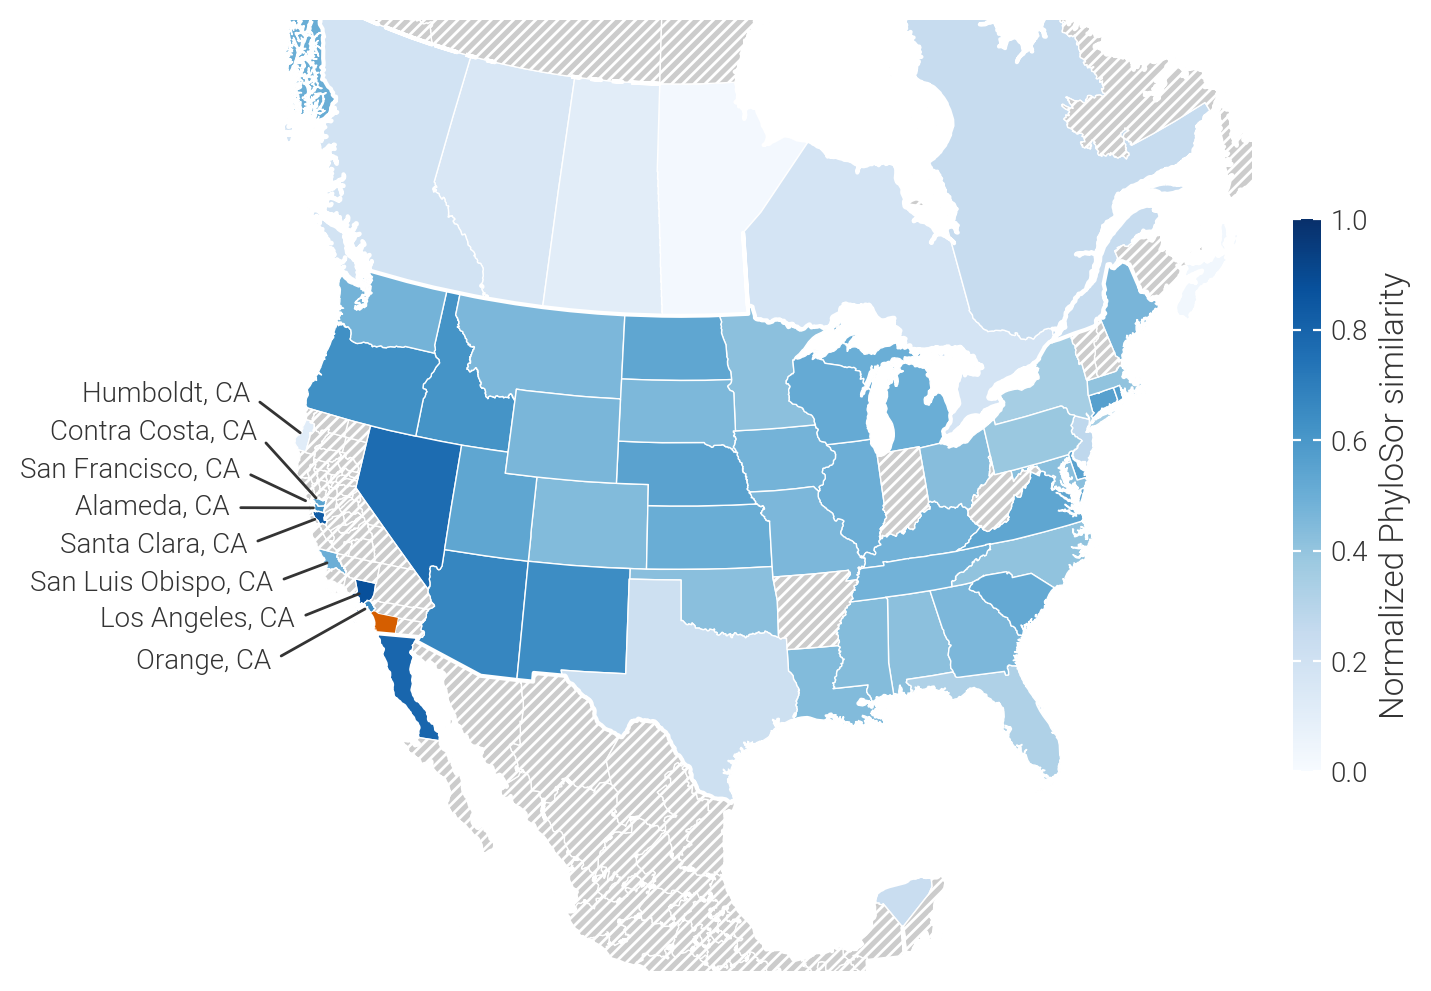

In [5]:
all = norm_values.columns
first_wave = ["2020-03-01", "2020-04-01", "2020-05-01", "2020-06-01", "2020-07-01", "2020-08-01"] # ("2020-01-01","2020-08-15")
second_wave = ["2020-11-01", "2020-12-01", "2021-01-01", "2021-02-01", "2021-03-01"] #( "2020-11-01", "2021-03-02" )
third_wave = ["2021-07-01", "2021-08-01", "2021-09-01", "2021-10-01", "2021-11-01"] #( "2021-07-01", "2022-03-02" )

median_list = list()
for wave, title in [(all, "median"), (first_wave, "First"), (second_wave, "second"), (third_wave, "third")]:
    medians = norm_values[wave].median( axis=1 )
    medians.name = title
    median_list.append( medians )

median_df = pd.concat( median_list, axis=1, ignore_index=False )

plot_df = states.merge( median_df, left_on="NAME", right_index=True, how="outer" )
plot_df

fig, ax = plt.subplots( dpi=200, figsize=(8,6) )
plot_df.plot( column="median", edgecolor="w", linewidth=0.5, ax=ax, cmap="Blues",
              vmin=0, vmax=1,
              missing_kwds={
                 "color": "#cccccc",
                 "hatch": "//////",
                 "label": "Missing values",
             } )

plot_df.loc[plot_df["COUNTRY"]=="CAN"].dissolve().boundary.plot( linewidth=1.5, edgecolor="w", ax=ax )
plot_df.loc[plot_df["COUNTRY"]=="MEX"].dissolve().boundary.plot( linewidth=1.5, edgecolor="w", ax=ax )
plot_df.loc[plot_df["NAME"]=="San Diego, CA"].plot( color="#D55E00", ax=ax )

arrowprops = dict(arrowstyle="-", relpos=(1,0.5), color=COLOR )
centroid = plot_df.loc[plot_df["NAME"]=="Alameda, CA", "geometry"].centroid
ax.annotate( "Alameda, CA", (centroid.x, centroid.y), (-60,0.1), textcoords='offset points', fontsize=10, ha="center", va="center", arrowprops=arrowprops )
centroid = plot_df.loc[plot_df["NAME"]=="Contra Costa, CA", "geometry"].centroid
ax.annotate( "Contra Costa, CA", (centroid.x, centroid.y), (-60,25), textcoords='offset points', fontsize=10, ha="center", va="center", arrowprops=arrowprops )
centroid = plot_df.loc[plot_df["NAME"]=="Humboldt, CA", "geometry"].centroid
ax.annotate( "Humboldt, CA", (centroid.x, centroid.y), (-50,15), textcoords='offset points', fontsize=10, ha="center", va="center", arrowprops=arrowprops )
centroid = plot_df.loc[plot_df["NAME"]=="Los Angeles, CA", "geometry"].centroid
ax.annotate( "Los Angeles, CA", (centroid.x, centroid.y), (-60,-10), textcoords='offset points', fontsize=10, ha="center", va="center", arrowprops=arrowprops )
centroid = plot_df.loc[plot_df["NAME"]=="Orange, CA", "geometry"].centroid
ax.annotate( "Orange, CA", (centroid.x, centroid.y), (-60,-20), textcoords='offset points', fontsize=10, ha="center", va="center", arrowprops=arrowprops )
centroid = plot_df.loc[plot_df["NAME"]=="San Francisco, CA", "geometry"].centroid
ax.annotate( "San Francisco, CA", (centroid.x, centroid.y), (-65,12), textcoords='offset points', fontsize=10, ha="center", va="center", arrowprops=arrowprops )
centroid = plot_df.loc[plot_df["NAME"]=="San Luis Obispo, CA", "geometry"].centroid
ax.annotate( "San Luis Obispo, CA", (centroid.x, centroid.y), (-65,-8), textcoords='offset points', fontsize=10, ha="center", va="center", arrowprops=arrowprops )
centroid = plot_df.loc[plot_df["NAME"]=="Santa Clara, CA", "geometry"].centroid
ax.annotate( "Santa Clara, CA", (centroid.x, centroid.y), (-60,-10), textcoords='offset points', fontsize=10, ha="center", va="center", arrowprops=arrowprops  )

cbar = fig.colorbar( mcm.ScalarMappable( cmap="Blues", norm=Normalize(vmin=0, vmax=1 ) ),
                   shrink=0.5, pad=0.03 )
cbar.outline.set_visible( False )
cbar.set_label( "Normalized PhyloSor similarity", fontsize=12 )
cbar.ax.tick_params( labelsize=10, size=3, left=True, right=True, color="w", direction="in", which="both" )


ax.set_xlim( (-3e6, 3e6) )
ax.set_ylim( (-3e6, 2e6) )
[ax.spines[j].set_visible(False) for j in ax.spines]
ax.set_yticks([])
ax.set_xticks([])
plt.tight_layout()
plt.savefig( "../analyses/plots/figure1_phylosor-map.pdf" )
plt.show()

Value = 0.14129711271027123; 95% CI, 0.008431340438024126 to 0.373945429902161


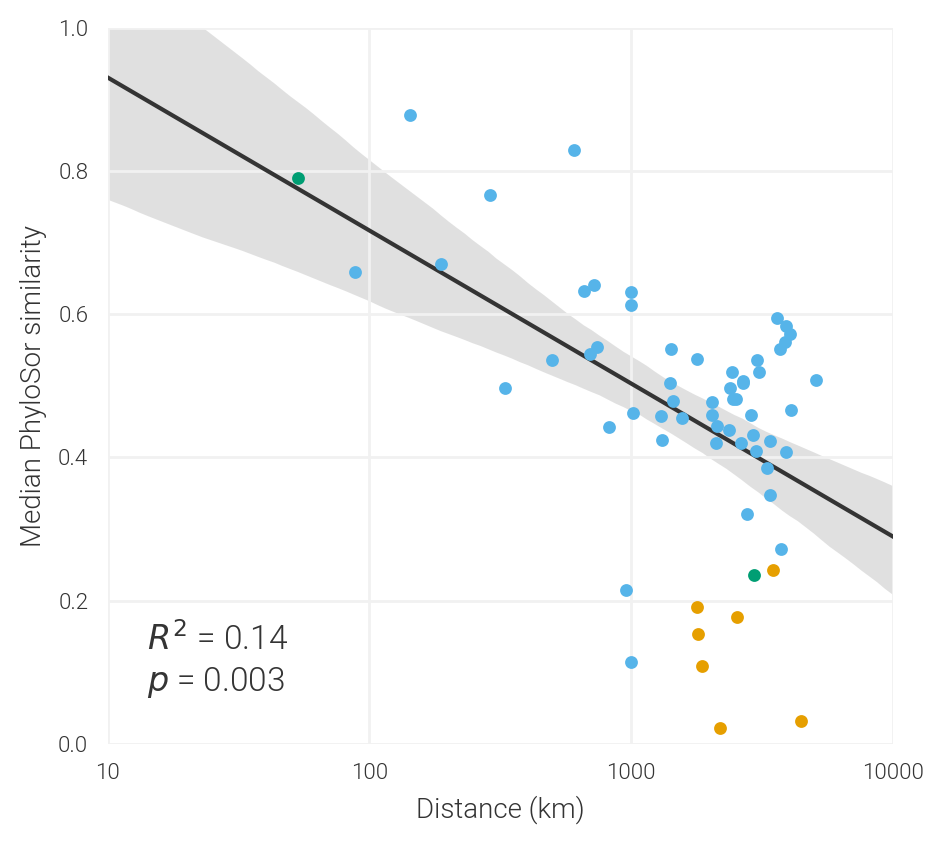

In [7]:
def get_coefficient( data, independent, dependent, bootstraps=1000 ):

    results = []
    for i in range(bootstraps):
        boot = data.sample( frac=1, replace=True )
        test_x = boot[independent].to_numpy().reshape(-1, 1)
        test_y = boot[dependent].to_numpy().reshape(-1, 1)
        results.append( spearmanr( test_x, test_y, nan_policy="omit" )[0]**2 )
    print( f"Value = {np.quantile( results, 0.5 )}; 95% CI, {np.quantile( results, 0.025 )} to {np.quantile( results, 0.975 )}" )

    test_x = data[dependent].to_numpy().reshape(-1, 1)
    test_y = data[independent].to_numpy().reshape(-1, 1)
    return np.quantile( results, 0.5 ), spearmanr( test_x, test_y, nan_policy="omit" )[1]

fig, ax = plt.subplots( dpi=200, figsize=(5,4.5) )

for loc, color in [ ("USA", "#56B4E9"), ("CAN", "#E69F00"), ("MEX", "#009E73")]:
    temp = plot_df.loc[plot_df["COUNTRY"]==loc]
    ax.scatter( x=temp["distance"], y=temp["median"], c=color, s=13, zorder=10 )

ax.set_ylim( 0, 1 )
ax.set_xlim( 1,4 )
ax.set_xticks( [1, 2, 3, 4] )
ax.set_xticklabels( [10, 100, 1000, 10000] )

sns.regplot( x="distance", y="median", data=plot_df, color=COLOR, scatter=False, line_kws={"zorder" : 5, "linewidth" : 1.5}, ax=ax, truncate=False )

ax.set_xlabel( "Distance (km)", fontsize=10 )
ax.set_ylabel( "Median PhyloSor similarity", fontsize=10 )

coeff = get_coefficient( plot_df.loc[~plot_df["median"].isna()], "distance" ,"median" )
ax.text( 0.05, 0.17, f"$R^2$ = {coeff[0]:.2f}", transform=ax.transAxes, fontsize=12, ha="left", va="top" )
ax.text( 0.05, 0.11, f"$p$ = {coeff[1]:.3f}", transform=ax.transAxes, fontsize=12, ha="left", va="top" )
ax.grid( which="both", axis="both", linewidth=1, color="#F1F1F1", zorder=1)
[ax.spines[j].set_visible(False) for j in ax.spines]
ax.tick_params( axis="x", bottom=False, which="both", labelbottom=True, labelsize=8 )
ax.tick_params( axis="y", left=False, which="both", labelsize=8 )


plt.tight_layout()
plt.savefig( "../analyses/plots/figure1_phylosor-distance.pdf" )
plt.show()

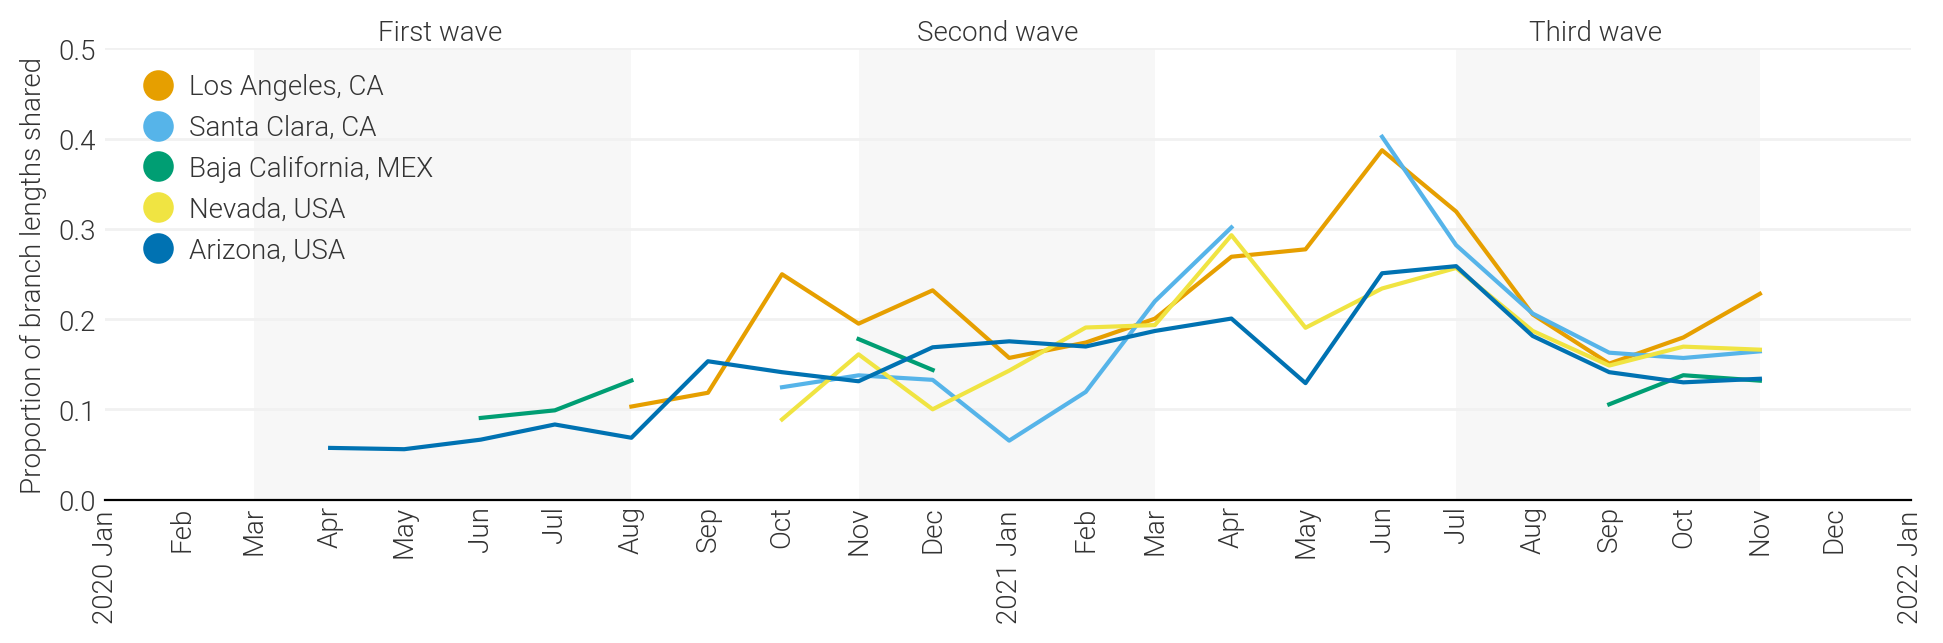

In [8]:
paired = get_okabe_ito_palette()
ps_df = calculate_order( res, normalize=False )
ps_df = ps_df.reindex( index=orders )
plot_df = ps_df.iloc[:5].melt( ignore_index=False ).reset_index()

fig, ax = plt.subplots( dpi=200, figsize=(10,3.5) )
count = 0
legend = []
for count, name in enumerate( orders[:5] ):
    ax.plot( "date", "value", data=plot_df.loc[plot_df["siteB"]==name], color=paired[count], zorder=100 )
    legend.append( Line2D([0], [0], linestyle='none', marker='o', color=paired[count], label=name, markersize=10 ) )
    count += 1

ax.legend( handles=legend, loc="upper left", handletextpad=0.1, frameon=False, fontsize=10 )
basic_formatting( ax, xlims=( pd.to_datetime("2020-01-01"), pd.to_datetime("2022-01-01") ), ylims=(0, 0.5), ylabel="Proportion of branch lengths shared", ysize=10, xsize=10 )

ax.axvspan( first_wave[0], first_wave[-1], zorder=0, color="#000000", alpha=0.03, linewidth=0 )
ax.annotate( "First wave", (pd.to_datetime( first_wave[0] ), 0.5), (67,3), textcoords="offset points", ha="center", fontsize=10 )
ax.axvspan( second_wave[0], second_wave[-1], zorder=0, color="#000000", alpha=0.03, linewidth=0 )
ax.annotate( "Second wave", (pd.to_datetime( second_wave[0] ), 0.5), (50,3), textcoords="offset points", ha="center", fontsize=10 )
ax.axvspan( third_wave[0], third_wave[-1], zorder=0, color="#000000", alpha=0.03, linewidth=0 )
ax.annotate( "Third wave", (pd.to_datetime( third_wave[0] ), 0.5), (50,3), textcoords="offset points", ha="center", fontsize=10 )

timeseries_formatting( ax )
plt.tight_layout()
plt.savefig( "../analyses/plots/figure1_phylosor-top-locations.pdf" )
plt.show()

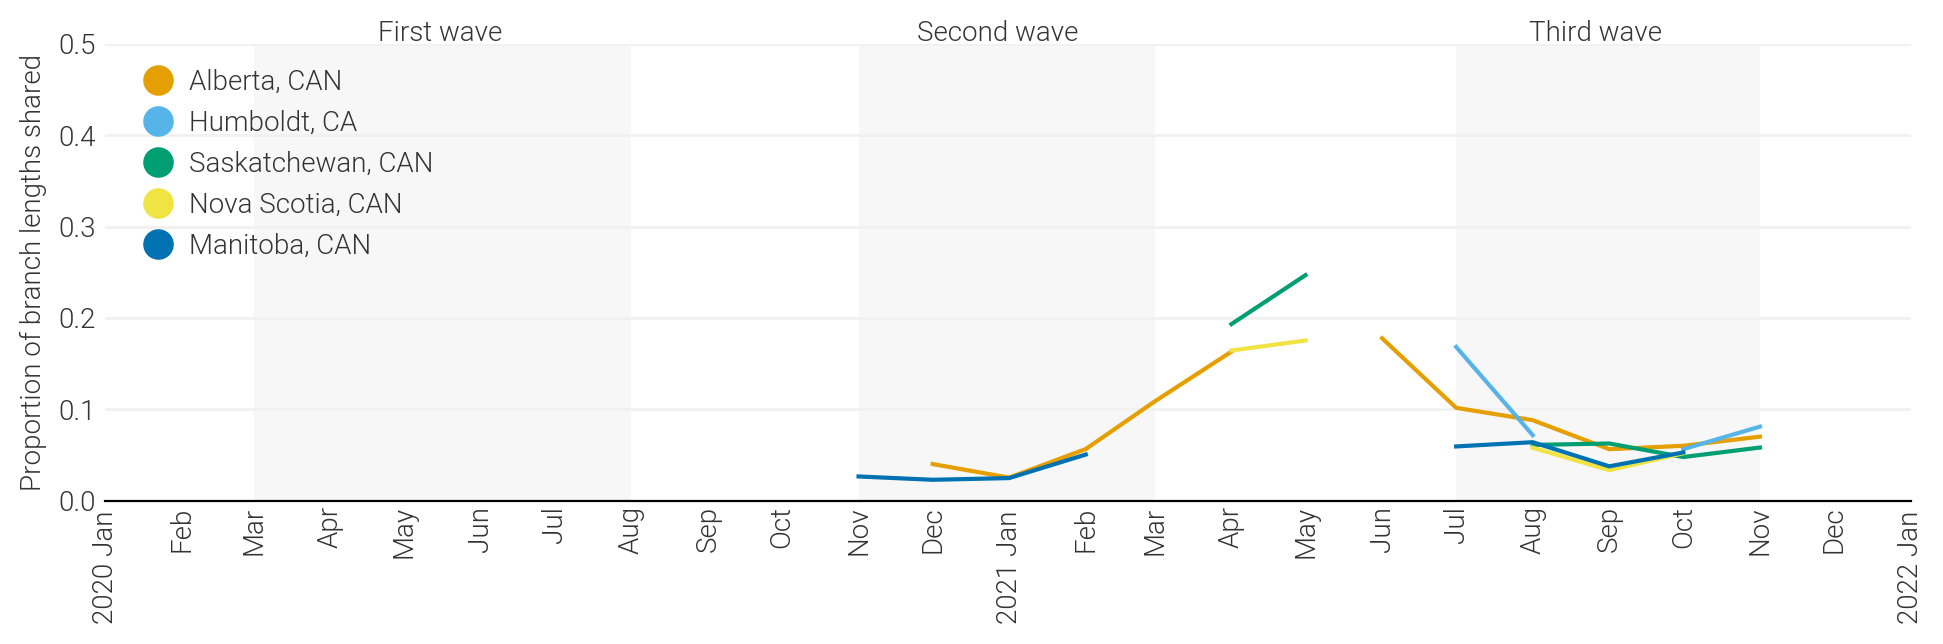

In [9]:
plot_df = ps_df.iloc[-5:].melt( ignore_index=False ).reset_index()

fig, ax = plt.subplots( dpi=200, figsize=(10,3.5) )
count = 0
legend = []
for count, name in enumerate( orders[-5:] ):
    ax.plot( "date", "value", data=plot_df.loc[plot_df["siteB"]==name], color=paired[count], zorder=100 )
    legend.append( Line2D([0], [0], linestyle='none', marker='o', color=paired[count], label=name, markersize=10 ) )
    count += 1

ax.legend( handles=legend, loc="upper left", handletextpad=0.1, frameon=False, fontsize=10 )
basic_formatting( ax, xlims=( pd.to_datetime("2020-01-01"), pd.to_datetime("2022-01-01") ), ylims=( 0, 0.5 ), ylabel="Proportion of branch lengths shared", ysize=10, xsize=10 )

ax.axvspan( first_wave[0], first_wave[-1], zorder=0, color="#000000", alpha=0.03, linewidth=0 )
ax.annotate( "First wave", (pd.to_datetime( first_wave[0] ), 0.5), (67,1), textcoords="offset points", ha="center", fontsize=10 )
ax.axvspan( second_wave[0], second_wave[-1], zorder=0, color="#000000", alpha=0.03, linewidth=0 )
ax.annotate( "Second wave", (pd.to_datetime( second_wave[0] ), 0.5), (50,1), textcoords="offset points", ha="center", fontsize=10 )
ax.axvspan( third_wave[0], third_wave[-1], zorder=0, color="#000000", alpha=0.03, linewidth=0 )
ax.annotate( "Third wave", (pd.to_datetime( third_wave[0] ), 0.5), (50,1), textcoords="offset points", ha="center", fontsize=10 )

timeseries_formatting( ax )
plt.tight_layout()
plt.savefig( "../analyses/plots/figure1_phylosor-bottom-locations.pdf" )
plt.show()

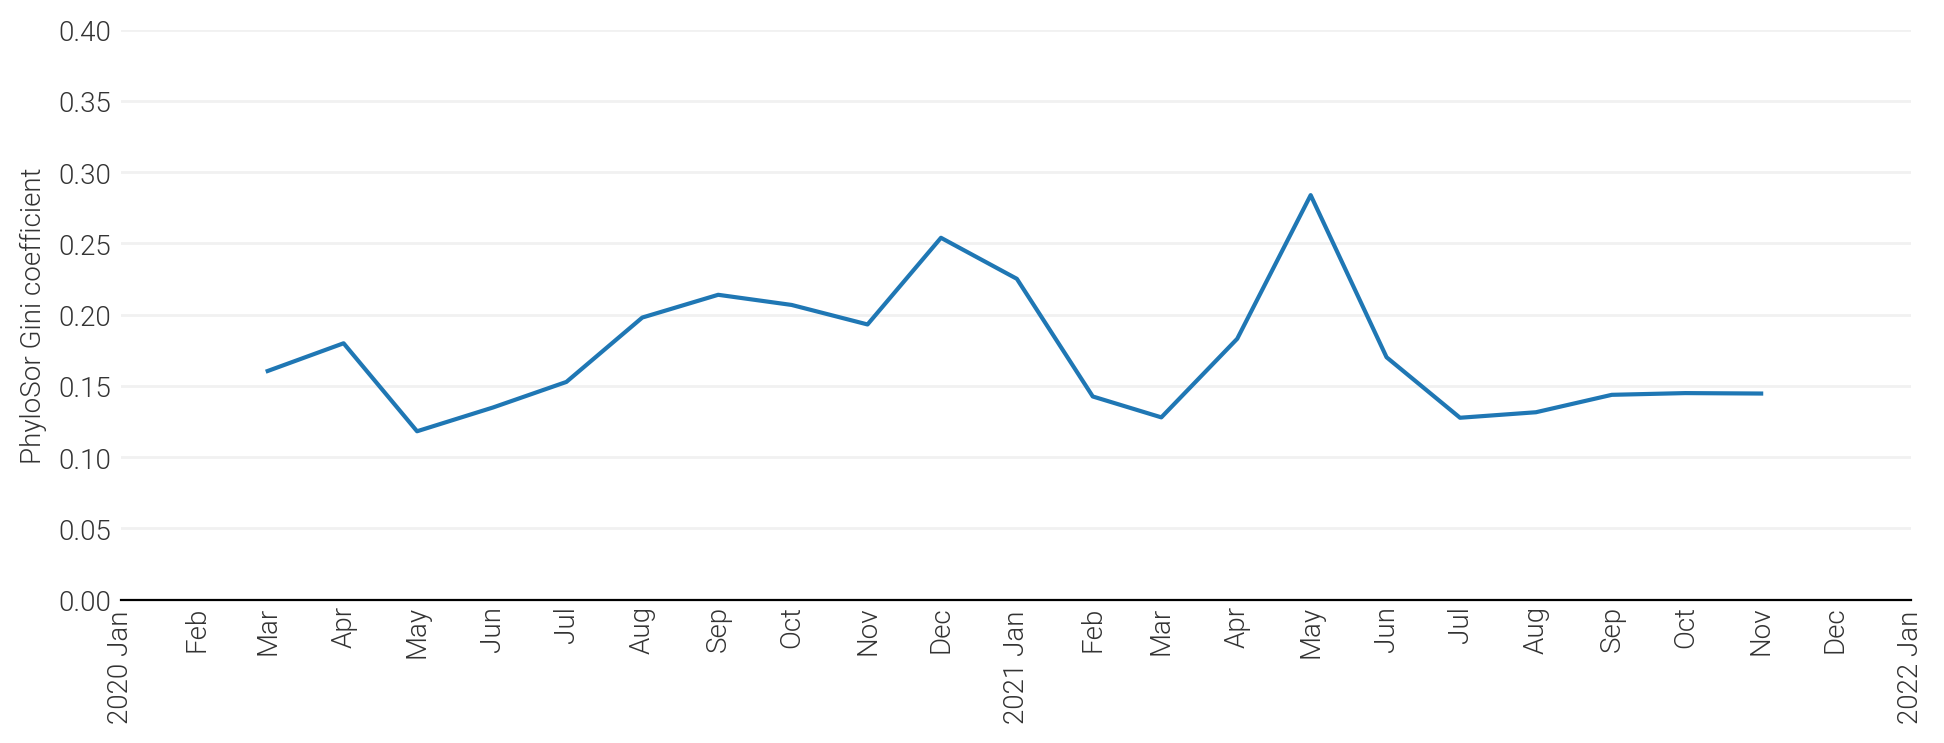

In [34]:
def gini(x, weights=None):
    if weights is None:
        weights = np.ones_like(x)
    # Calculate mean absolute deviation in two steps, for weights.
    count = np.multiply.outer(weights, weights)
    mad = np.abs(np.subtract.outer(x, x) * count).sum() / count.sum()
    rmad = mad / np.average(x, weights=weights)
    # Gini equals half the relative mean absolute deviation.
    return 0.5 * rmad

fig, ax = plt.subplots( dpi=200, figsize=(10,4) )
count = 0
plot_df = calculate_order(res, normalize=False )
plot_df = plot_df.apply( lambda x: gini( x.dropna().to_numpy() ) )
ax.plot( plot_df.index, plot_df)

basic_formatting( ax, xlims=( pd.to_datetime("2020-01-01"), pd.to_datetime("2022-01-01") ), ylims=(0, 0.4), ylabel="PhyloSor Gini coefficient", ysize=10, xsize=10 )
timeseries_formatting( ax )
plt.tight_layout()
plt.show()

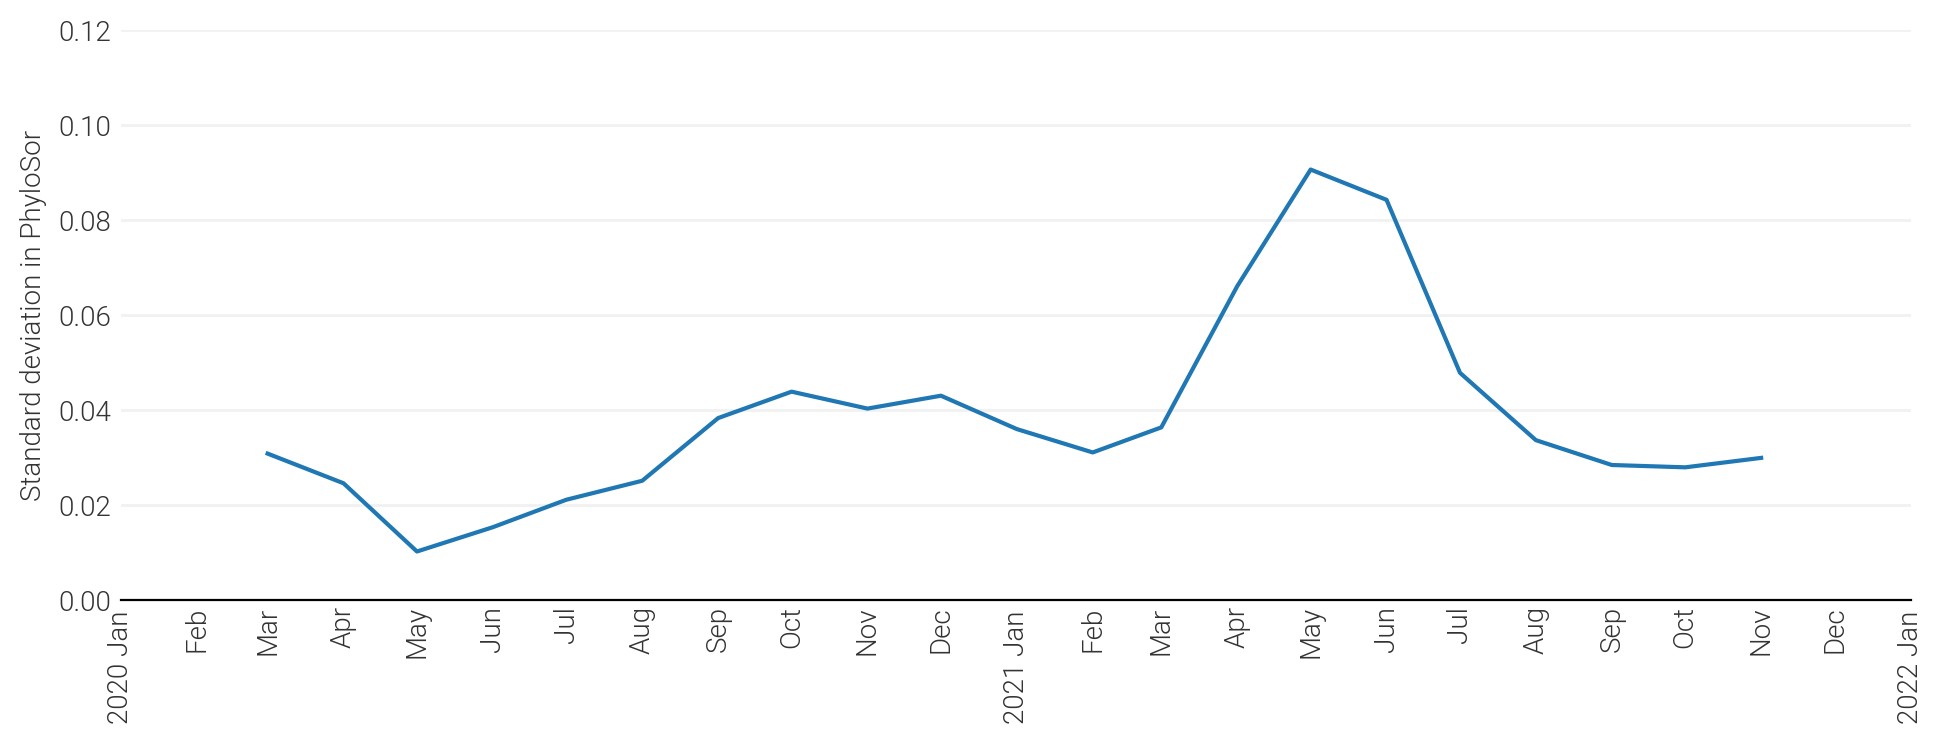

In [151]:
fig, ax = plt.subplots( dpi=200, figsize=(10,4) )
count = 0
plot_df = calculate_order(res, normalize=False ).std()
plot_df.to_csv( "../data/phylosor_std.csv" )
ax.plot( plot_df.index, plot_df)

basic_formatting( ax, xlims=( pd.to_datetime("2020-01-01"), pd.to_datetime("2022-01-01") ), ylims=(0, 0.12), ylabel="Standard deviation in PhyloSor", ysize=10, xsize=10 )
timeseries_formatting( ax )
plt.tight_layout()
plt.savefig( "../analyses/plots/figure1_phylosor-deviation.pdf" )
plt.show()

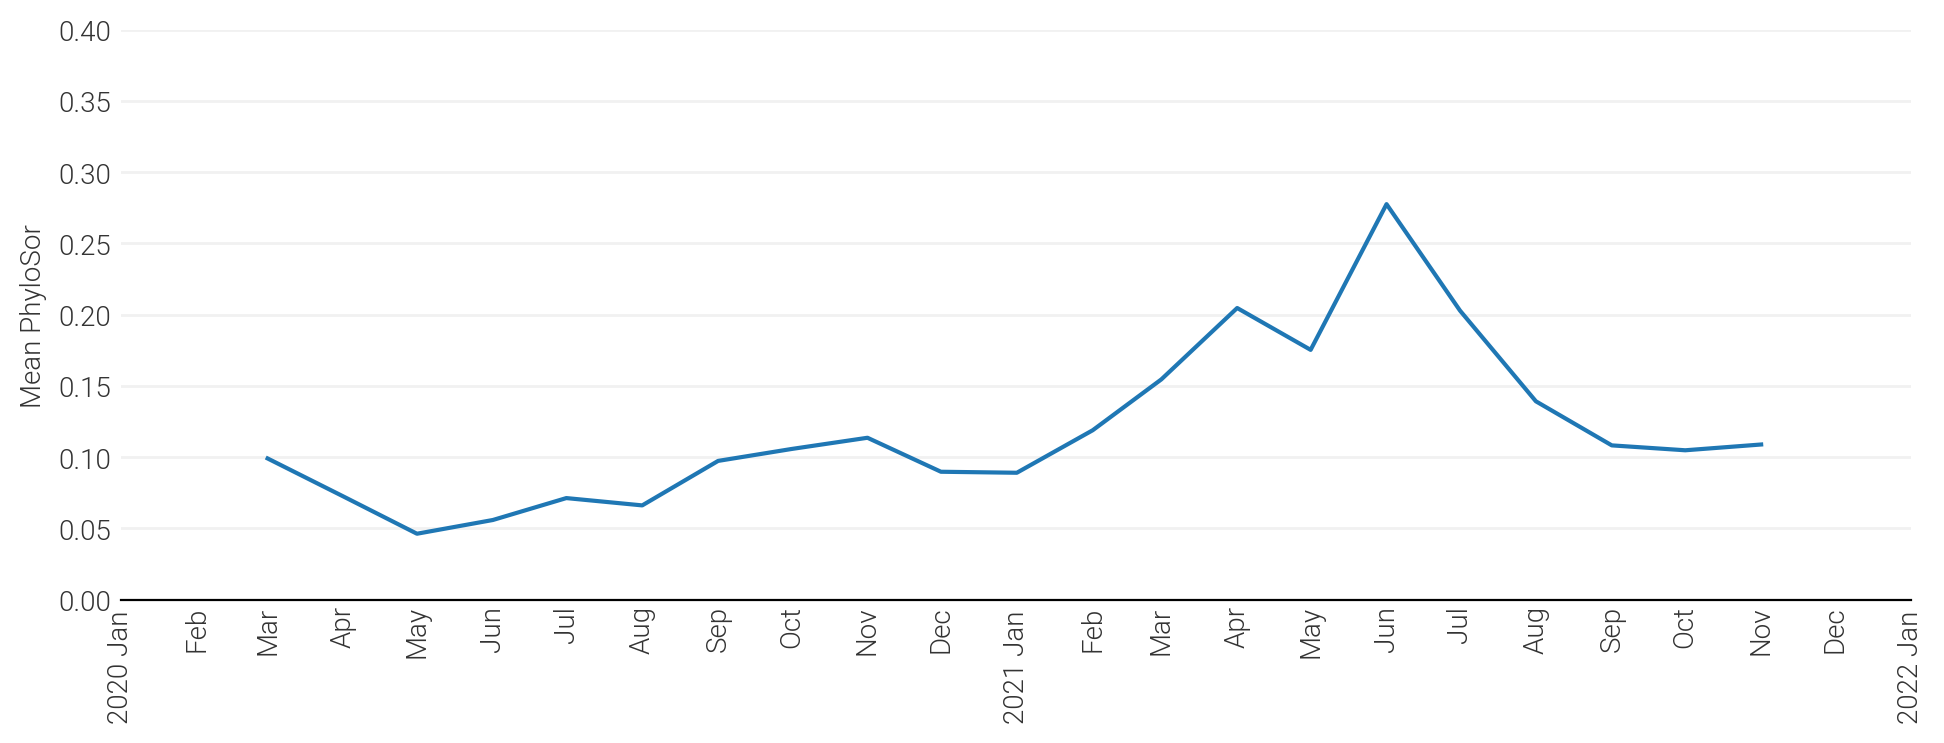

In [28]:
fig, ax = plt.subplots( dpi=200, figsize=(10,4) )
count = 0
plot_df = calculate_order(res, normalize=False ).mean()
plot_df.to_csv( "../data/phylosor_std.csv" )
ax.plot( plot_df.index, plot_df)

basic_formatting( ax, xlims=( pd.to_datetime("2020-01-01"), pd.to_datetime("2022-01-01") ), ylims=(0, 0.4), ylabel="Mean PhyloSor", ysize=10, xsize=10 )
timeseries_formatting( ax )
plt.tight_layout()
plt.savefig( "../analyses/plots/figure1_phylosor-mean.pdf" )
plt.show()

# Diagnostic plots
We filtered comparisons in which either location had less than 30 sequences. To determine how we arrived at that threshold, the following graphs were consulted.

In [7]:
medians = []
ranks = []
counts = []

test_values = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for count in test_values:
    res = load_results( loc="../data/phylosor_newnull_results.csv", source="San Diego_CA", min_sequences=count )
    orders = calculate_order( res )
    median = orders.median( axis=1 )
    median.name = count
    rank = median.rank( ascending=False )
    rank.name = count
    nonna = orders.count( axis=1 )
    nonna.name = count

    medians.append( median )
    ranks.append( rank )
    counts.append( nonna )

medians = pd.concat( medians, axis=1, ignore_index=False )
plot_order = medians[1].sort_values().index
medians_corr = medians.corr()
medians = medians.melt( var_name="min_sequences", value_name="median_value", ignore_index=False ).reset_index()
ranks = pd.concat( ranks, axis=1, ignore_index=False )
ranks = ranks.melt( var_name="min_sequences", value_name="rank", ignore_index=False ).reset_index()
counts = pd.concat( counts, axis=1, ignore_index=False )
counts = counts.melt( var_name="min_sequences", value_name="nonnull_months", ignore_index=False ).reset_index()

plot_df = medians.merge( counts ).merge( ranks )
plot_df.head()

,siteB,min_sequences,median_value,nonnull_months,rank
0,Alabama_USA,1,0.475518,21,31.0
1,Alameda_CA,1,0.609416,21,9.0
2,Alaska_USA,1,0.528372,18,16.0
3,Alberta_CAN,1,0.243547,20,58.0
4,Arizona_USA,1,0.630658,22,6.0


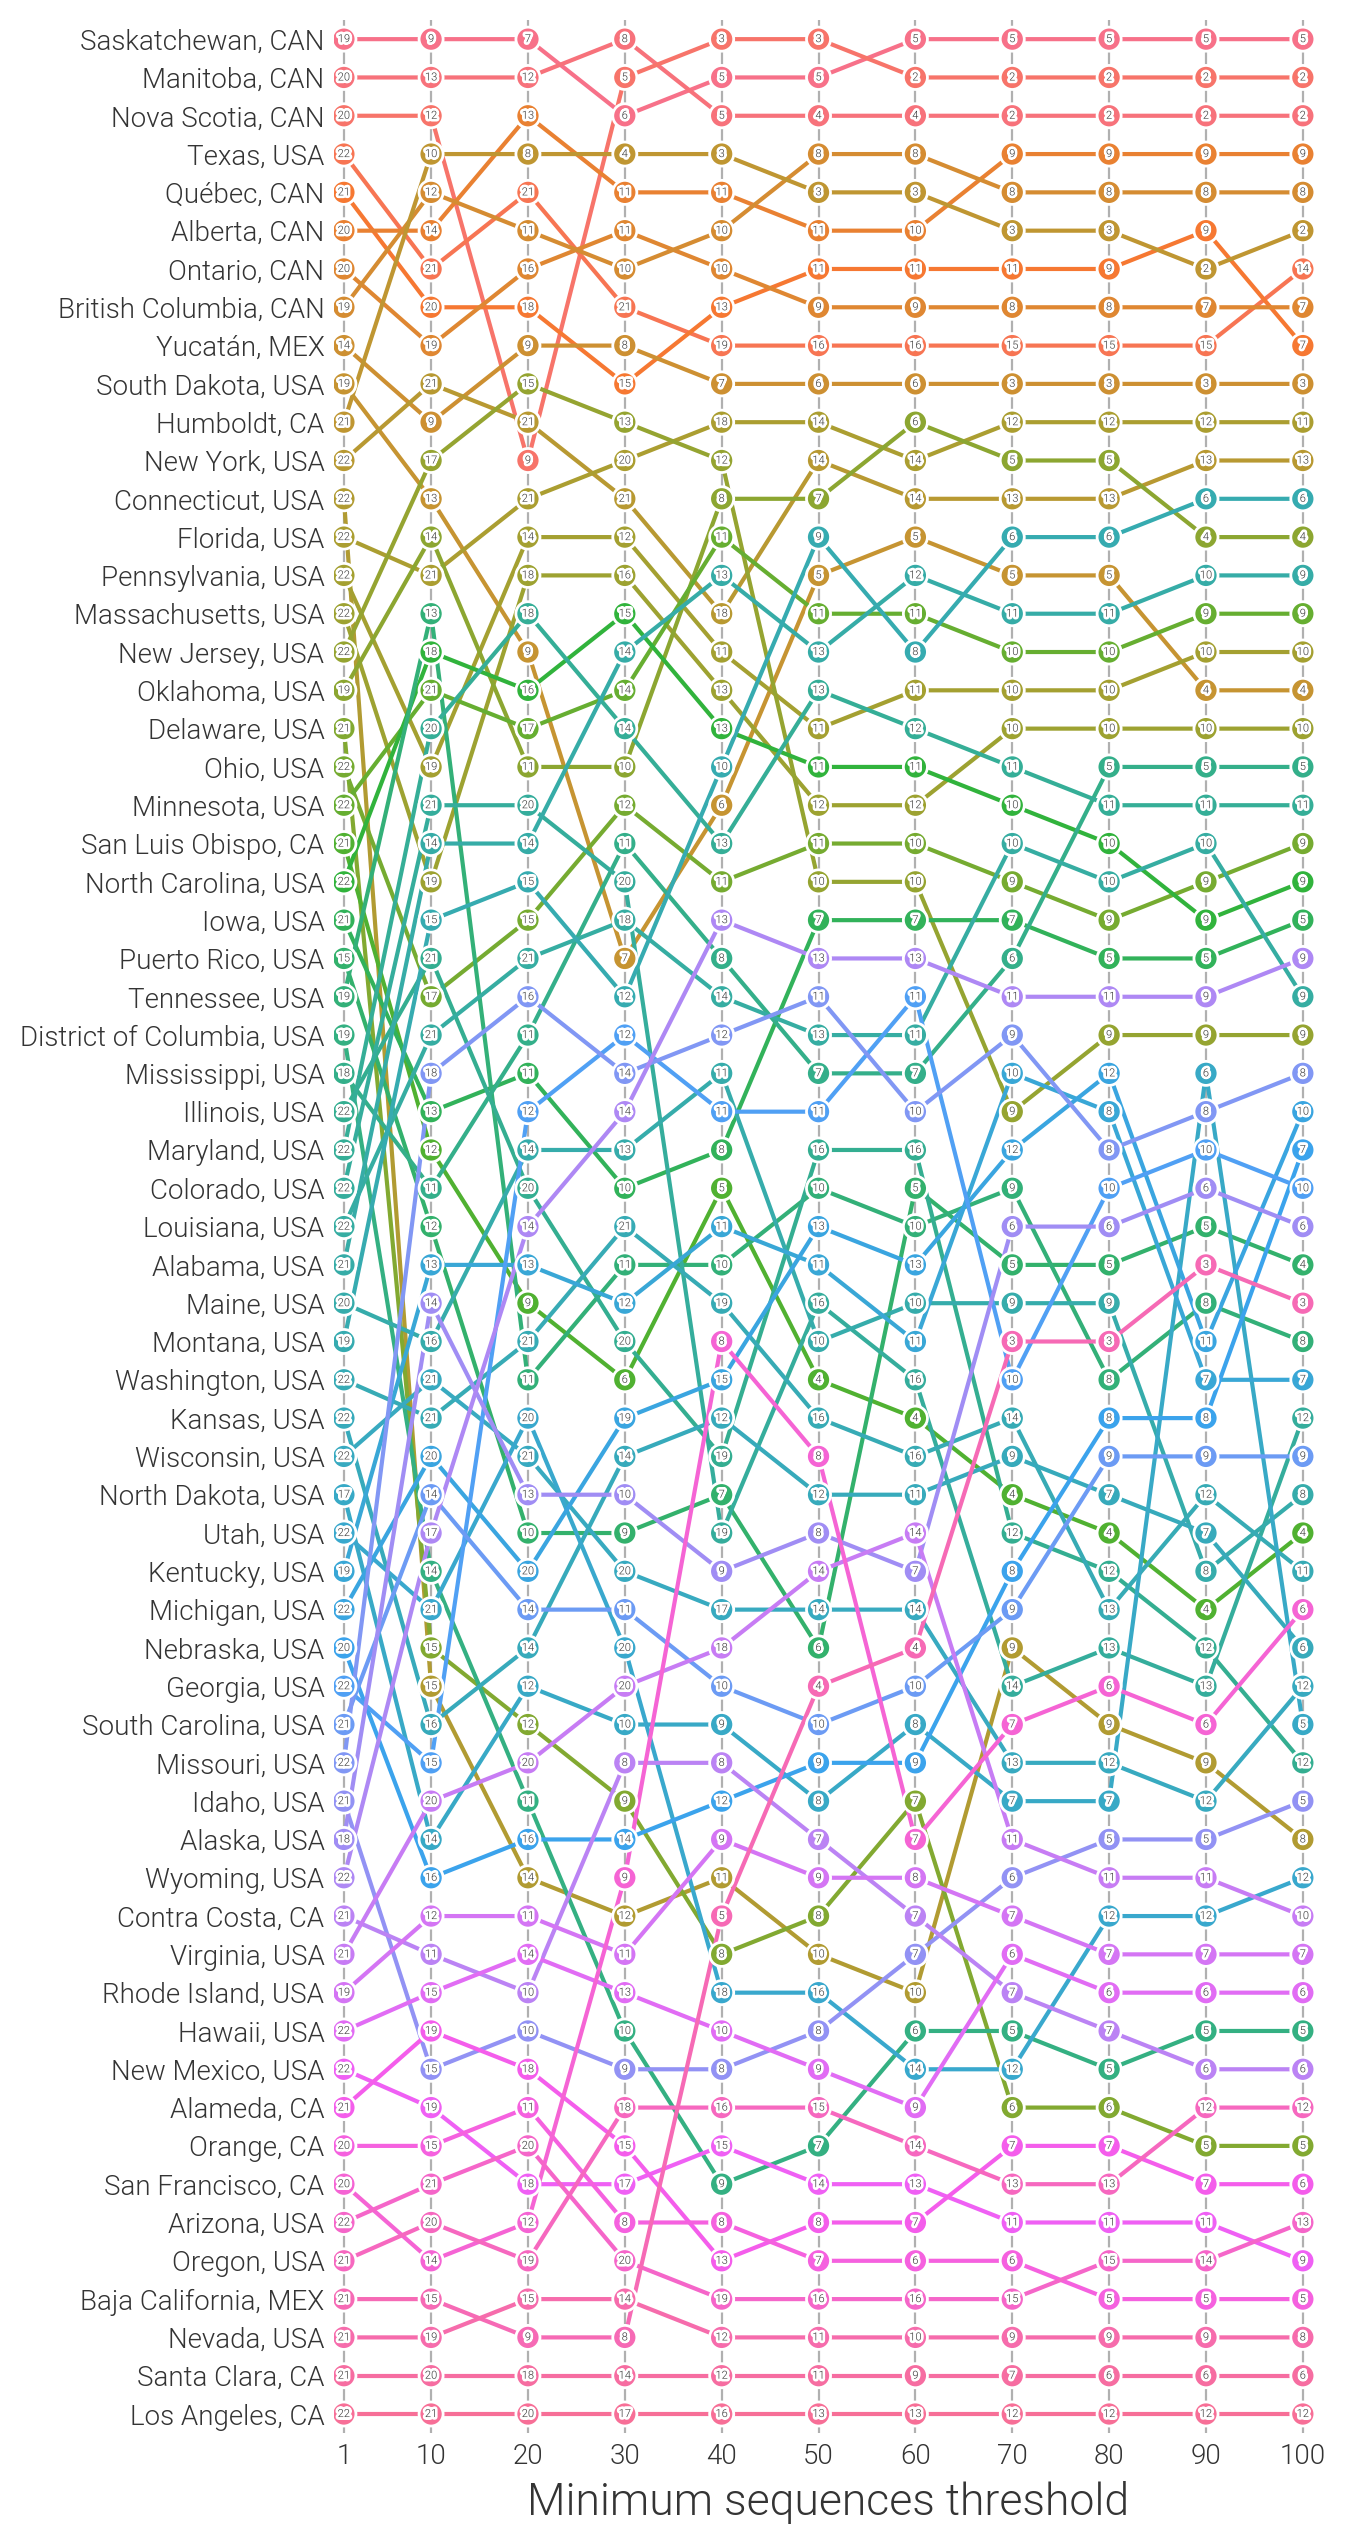

In [9]:
fig, ax = plt.subplots( dpi=200, figsize=(7,13) )
sns.lineplot( x="min_sequences", y="rank", hue="siteB", data=plot_df, hue_order=plot_order, zorder=100, ax=ax )
sns.scatterplot( x="min_sequences", y="rank", hue="siteB", data=plot_df, s=75, hue_order=plot_order, zorder=101, ax=ax, linewidth=1)

for _, i in plot_df.iterrows():
    txt = ax.text( x=i["min_sequences"], y=i["rank"], s=f'{i["nonnull_months"]:.0f}', zorder=105, ha="center", va="center", fontsize=4 )
    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

ax.set_xticks( test_values )
ax.set_xlim( 0, test_values[-1]+2 )
ax.set_xlabel( "Minimum sequences threshold" )
ax.tick_params( axis="x", bottom=False, which="both", labelbottom=True, labelsize=10, pad=0 )
ax.set_yticks( range(1, len( plot_order ) + 1 ) )
ax.set_yticklabels( reversed( plot_order.map( lambda x: x.replace( "_", ", " ) ) ) )
ax.set_ylabel( "" )
ax.set_ylim( 0.5, len( plot_order ) + 0.5 )
ax.tick_params( axis="y", left=False, which="both", labelleft=True, labelsize=10, pad=0 )
[ax.spines[j].set_visible( False ) for j in ax.spines]
ax.legend().remove()
ax.grid( axis="x", zorder=1 )
plt.tight_layout()
plt.show()

NameError: name 'plot_order' is not defined

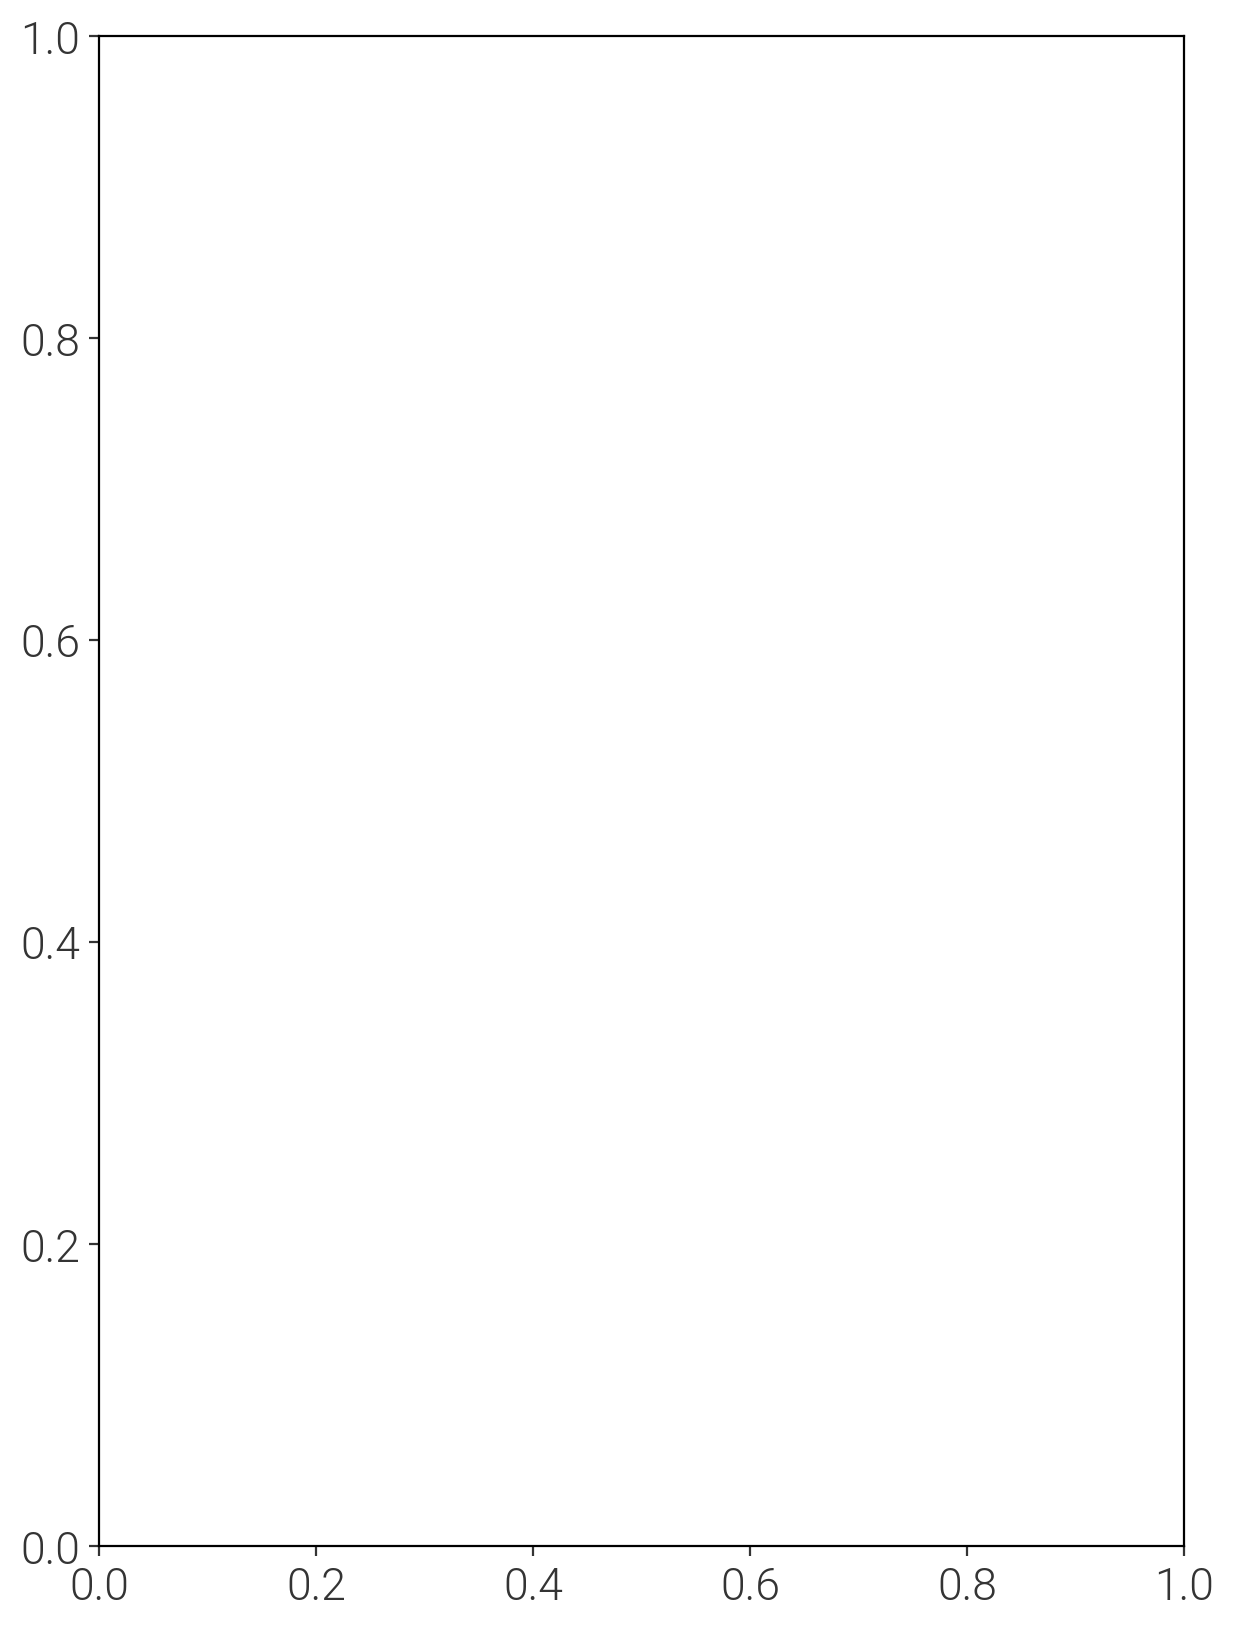

In [110]:
fig, ax = plt.subplots( dpi=200, figsize=(7,10) )
sns.lineplot( x="min_sequences", y="median_value", hue="siteB", data=plot_df, hue_order=plot_order, zorder=100, ax=ax )
ax.legend().remove()

Ranks are moving around a bit, but this probably isn't as big of an effect as it looks. If we compare the correlation between median values from one threshold to the next, we see that median values correlate with R values greater than 93%. We choose 30 because it inidicates the greatest increase in stability of median values.

In [10]:
pd.Series( np.diagonal( medians_corr, 1 ), index=medians_corr.columns[1:] )

10     0.960898
20     0.967847
30     0.965331
40     0.977274
50     0.989802
60     0.997069
70     0.992363
80     0.999336
90     0.996351
100    0.995266
dtype: float64